In [3]:
# Modules will be reloaded every time a cell is executed
%load_ext autoreload
%autoreload 2

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier


from models.seeds import SEED_TYPES
from models.constants import SEEDS_TO_COUNT, SEED_COUNT_COLUMNS
from utils.plots import plot_feature_importance


In [5]:
FOLDER_PATH = "data/preprocessed_for_ml/"
TRAIN_OUTPUT_FEATURES_PATH = Path(
    FOLDER_PATH + '3utr.sequences.refseq_id.mirna_fc.seed_cls.sequence.signal.conservation.seed_cls.ts_preds.train.pkl'
)
TEST_OUTPUT_FEATURES_PATH = Path(
    FOLDER_PATH + '3utr.sequences.refseq_id.mirna_fc.seed_cls.sequence.signal.conservation.seed_cls.ts_preds.test.pkl'
)

TRAIN_OUTPUT_FEATURES_PATH, TEST_OUTPUT_FEATURES_PATH

(PosixPath('data/preprocessed_for_ml/3utr.sequences.refseq_id.mirna_fc.seed_cls.sequence.signal.conservation.seed_cls.ts_preds.train.pkl'),
 PosixPath('data/preprocessed_for_ml/3utr.sequences.refseq_id.mirna_fc.seed_cls.sequence.signal.conservation.seed_cls.ts_preds.test.pkl'))

In [21]:
utils.check_random_state(3)
np.random.seed(1)

In [23]:
COLUMNS_FOR_PRED = [
    'transcript_length',
    'signal_binding_sites_count', 'signal_max', 'mean', 'std',
    'median', 'iqr', 'peak_count', 'mean_crossings'
]
COLUMNS_FOR_PRED.extend(SEEDS_TO_COUNT)
COLUMNS_FOR_PRED.extend(SEED_COUNT_COLUMNS)

In [7]:
data_train = pd.read_pickle(TRAIN_OUTPUT_FEATURES_PATH)
data_test = pd.read_pickle(TEST_OUTPUT_FEATURES_PATH)

In [27]:
x_seeds_train = data_train[SEED_COUNT_COLUMNS]
y_train = data_train.label

x_seeds_test = data_test[SEED_COUNT_COLUMNS]
y_test = data_test.label

In [52]:
x_seeds_signal_train = data_train[COLUMNS_FOR_PRED].fillna(0,inplace=False)
x_seeds_signal_test = data_test[COLUMNS_FOR_PRED].fillna(0,inplace=False)

### Train seed-based-only models

#### Logistic regression

In [14]:
model = LogisticRegression(max_iter=1000)
model.fit(x_seeds_train, y_train)

y_pred_seeds_lr_train = model.predict_proba(x_seeds_train)
y_pred_seeds_lr_test = model.predict_proba(x_seeds_test)

#### (Histogram) Gradient Boosting Classifier

In [71]:
model_seeds_tree = GradientBoostingClassifier()
model_seeds_tree.fit(x_seeds_train, y_train)

y_pred_seeds_tree_train = model_seeds_tree.predict_proba(x_seeds_train)
y_pred_seeds_tree_test = model_seeds_tree.predict_proba(x_seeds_test)

### Train seed and signal based models

#### Logistic regression

In [53]:
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(x_seeds_signal_train, y_train)

y_pred_seeds_signal_lr_train = model_lr.predict_proba(x_seeds_signal_train)
y_pred_seeds_signal_lr_test = model_lr.predict_proba(x_seeds_signal_test)

#### (Histogram) Gradient Boosting Classifier

In [72]:
model_tree = GradientBoostingClassifier()
model_tree.fit(x_seeds_signal_train, y_train)

y_pred_seeds_signal_tree_train = model_tree.predict_proba(x_seeds_signal_train)
y_pred_seeds_signal_tree_test = model_tree.predict_proba(x_seeds_signal_test)

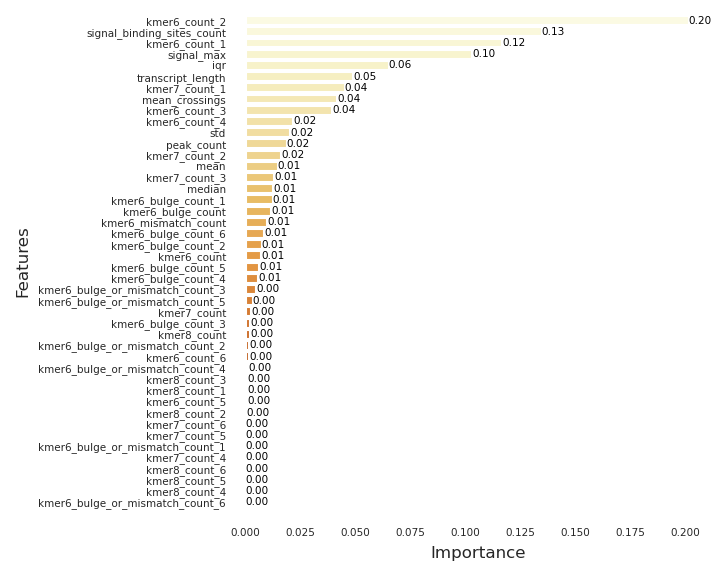

In [57]:
feature_importances = model_tree.feature_importances_
feature_names = x_seeds_signal_train.columns

plot_feature_importance(feature_names, feature_importances)

In [59]:
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb

# Train an XGBOOST classifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_classifier.fit(x_seeds_signal_train, y_train)

# Make predictions with XGBOOST
xgb_y_pred_class = xgb_classifier.predict(x_seeds_signal_test)
xgb_y_pred = xgb_classifier.predict_proba(x_seeds_signal_test)

# Evaluate the XGBOOST classifier
xgb_accuracy = accuracy_score(y_test, xgb_y_pred_class)
xgb_report = classification_report(y_test, xgb_y_pred_class)

print(f'Accuracy (XGBoost): {xgb_accuracy}')
print('Classification Report (XGBoost):')
print(xgb_report)

Accuracy (XGBoost): 0.6625906441063557
Classification Report (XGBoost):
              precision    recall  f1-score   support

         0.0       0.69      0.90      0.78      9311
         1.0       0.50      0.19      0.28      4755

    accuracy                           0.66     14066
   macro avg       0.59      0.55      0.53     14066
weighted avg       0.62      0.66      0.61     14066



In [60]:
from sklearn.ensemble import RandomForestClassifier

# Train a RANDOM FOREST classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(x_seeds_signal_train, y_train)

# Make predictions
rf_y_pred_class = rf_classifier.predict(x_seeds_signal_test)
rf_y_pred = rf_classifier.predict_proba(x_seeds_signal_test)

# Evaluate the classifier
rf_accuracy = accuracy_score(y_test, rf_y_pred_class)
rf_report = classification_report(y_test, rf_y_pred_class)

print(f'Accuracy (Random Forest): {rf_accuracy}')
print('Classification Report (Random Forest):')
print(rf_report)

Accuracy (Random Forest): 0.6638703256078488
Classification Report (Random Forest):
              precision    recall  f1-score   support

         0.0       0.68      0.92      0.78      9311
         1.0       0.51      0.16      0.25      4755

    accuracy                           0.66     14066
   macro avg       0.60      0.54      0.52     14066
weighted avg       0.62      0.66      0.60     14066



In [62]:
from sklearn.svm import SVC

svm_preds = {}
# for kernel in ['linear', 'poly', 'sigmoid', 'rbf']:
for kernel in ['rbf']:
    # Train a SVM classifier
    svm_classifier = SVC(kernel=kernel, random_state=42, probability=True, verbose=False, max_iter=5000) # class_weight = 'balanced'
    svm_classifier.fit(x_seeds_signal_train, y_train)

    # Make predictions with SVM
    # svm_y_pred = svm_classifier.predict(X_test)
    svm_y_pred_class = svm_classifier.predict(x_seeds_signal_test)
    svm_y_pred = svm_classifier.predict_proba(x_seeds_signal_test)
    svm_preds[kernel] = svm_y_pred

    # Evaluate the SVM classifier
    svm_accuracy = accuracy_score(y_test, svm_y_pred_class)
    svm_report = classification_report(y_test, svm_y_pred_class)

    print(kernel)
    print(f'Accuracy (SVM): {svm_accuracy}')
    print('Classification Report (SVM):')
    print(svm_report)

/home/jovyan/my-conda-envs/deepExpTorch2/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


rbf
Accuracy (SVM): 0.40260201905303566
Classification Report (SVM):
              precision    recall  f1-score   support

         0.0       0.65      0.22      0.32      9311
         1.0       0.33      0.77      0.47      4755

    accuracy                           0.40     14066
   macro avg       0.49      0.49      0.39     14066
weighted avg       0.54      0.40      0.37     14066



In [63]:
y_targetscan_weighted_test = data_test['label']
y_pred_targetscan_weighted_test = data_test['weighted context++ score percentile'].fillna(0,inplace=False)

In [64]:
y_targetscan_weighted_train = data_train['label']
y_pred_targetscan_weighted_train = data_train['weighted context++ score percentile'].fillna(0,inplace=False)

14066  total test samples


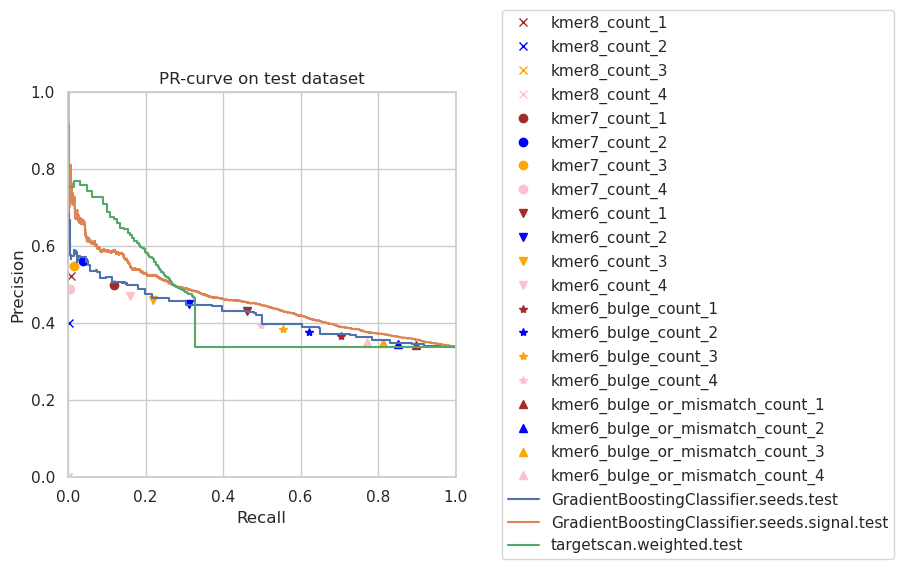

In [81]:
from models.seeds import plot_prc_with_seeds

_, ax = plot_prc_with_seeds(
    data_test, 
    SEED_TYPES, 
    {
        # 'logistic_regression.seeds.test': {
        #     'actual':y_test, 
        #     'predicted':y_pred_seeds_lr_test[:,1],
        # },
        # 'logistic_regression.seeds.signal.test': {
        #     'actual':y_test, 
        #     'predicted':y_pred_seeds_signal_lr_test[:,1],
        # },
        'GradientBoostingClassifier.seeds.test': {
            'actual':y_test, 
            'predicted':y_pred_seeds_tree_test[:,1],
        },
        'GradientBoostingClassifier.seeds.signal.test': {
            'actual':y_test, 
            'predicted':y_pred_seeds_signal_tree_test[:,1],
        },
        # 'xgb.seeds.signal.test':{
        #     'actual':y_test, 
        #     'predicted':xgb_y_pred[:,1],
        # },
        # 'random_forest.seeds.signal.test':{
        #     'actual':y_test, 
        #     'predicted':rf_y_pred[:,1],
        # },
        # 'svm.seeds.signal.test':{
        #     'actual':y_test, 
        #     'predicted':svm_y_pred[:,1],
        # },
        'targetscan.weighted.test': {
            'actual':y_targetscan_weighted_test, 
            'predicted':y_pred_targetscan_weighted_test,
        },
    },
    title='PR-curve on test dataset',
)
print(len(y_test), ' total test samples')

14066  total train samples


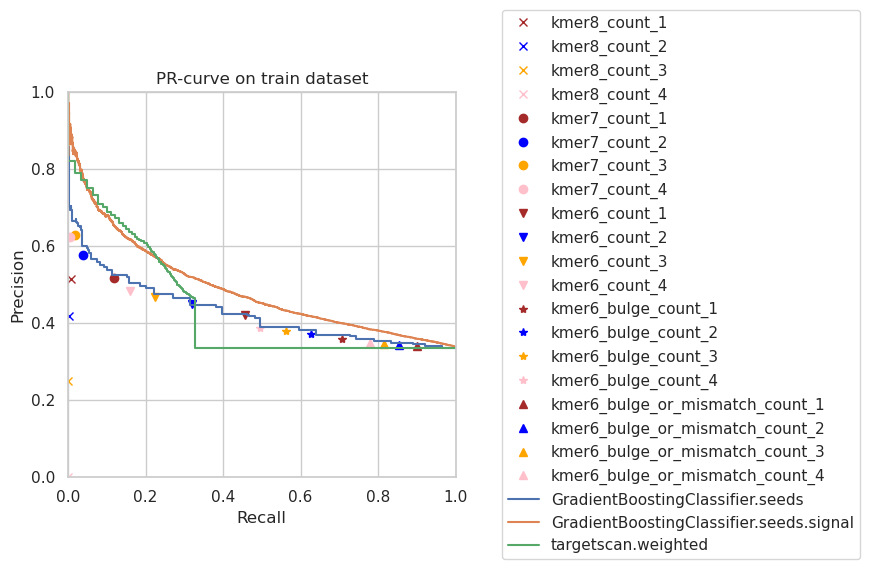

In [83]:
_, ax = plot_prc_with_seeds(
    data_train, 
    SEED_TYPES, 
    {
        # 'logistic_regression.seeds': {
        #     'actual':y_train, 
        #     'predicted':y_pred_seeds_lr_train[:,1],
        # },
        # 'logistic_regression.seeds.signal': {
        #     'actual':y_train, 
        #     'predicted':y_pred_seeds_signal_lr_train[:,1],
        # },
        'GradientBoostingClassifier.seeds': {
            'actual':y_train, 
            'predicted':y_pred_seeds_tree_train[:,1],
        },
        'GradientBoostingClassifier.seeds.signal': {
            'actual':y_train, 
            'predicted':y_pred_seeds_signal_tree_train[:,1],
        },
        f'targetscan.weighted': {
            'actual':y_train, 
            'predicted':y_pred_targetscan_weighted_train,
        },
    },
    title='PR-curve on train dataset',
)
print(len(y_test), ' total train samples')

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn import utils

utils.check_random_state(3) #2, 42
np.random.seed(1)

# X = data_train_copy.drop(
#      [*reference_columns, 'sequence',
#      'fold_change', 'label', *columns_to_aggregate,\
#      'seed_location_aggregate', 'signal', 'conservation_phylo', 'signal_high_pass',
#      *SEED_COUNT_COLUMNS],
#     axis=1
# )
X = data_train_copy[[*columns_for_pred, *SEED_COUNT_COLUMNS]].fillna(0,inplace=False)
y_fc = data_train_copy.fold_change

print(X.columns)

# Fit the model
# model_lr = LogisticRegression(max_iter=1000)
# model_lr.fit(X, y_seeds_signal)

# Histogram-based Gradient Boosting Classification Tree.
# model_tree_signal_fc = HistGradientBoostingRegressor()
model_tree_signal_fc = GradientBoostingRegressor()
model_tree_signal_fc.fit(X, y_fc)

# Coefficients
# print("Coefficients:", model_lr.coef_)

In [ ]:
# X_test = data_test_copy.drop(
#      [*reference_columns, 'sequence',
#      'fold_change', 'label', *columns_to_aggregate,\
#      'seed_location_aggregate', 'signal', 'conservation_phylo', 'signal_high_pass',
#      *SEED_COUNT_COLUMNS],
#     axis=1
# )
X_test = data_test_copy[[*columns_for_pred, *SEED_COUNT_COLUMNS]].fillna(0,inplace=False)


In [ ]:
y_pred_seeds_signal_tree_train_fc = model_tree_signal_fc.predict(X)
y_pred_seeds_signal_tree_test_fc = model_tree_signal_fc.predict(X_test)

In [ ]:
from utils.plots import plot_correlation

In [ ]:
plot_correlation(
    data_test_copy.fold_change, 
    y_pred_seeds_signal_tree_test_fc,
    title_sufix='Ours - Test set'
)

In [ ]:
y_pred_seeds_signal_tree_test_fc_positive_preds_zeroed = [x if x<0 else 0 for x in y_pred_seeds_signal_tree_test_fc]

In [ ]:
plot_correlation(
    data_test_copy.fold_change, 
    y_pred_seeds_signal_tree_test_fc_positive_preds_zeroed,
)

In [ ]:
test_fc_positive_preds_zeroed = [x if x<0 else 0 for x in data_test_copy.fold_change.values]

plot_correlation(
    test_fc_positive_preds_zeroed, 
    y_pred_seeds_signal_tree_test_fc_positive_preds_zeroed,
)

In [ ]:
train_fc_positive_preds_zeroed = [x if x<0 else 0 for x in data_train_copy.fold_change.values]
y_pred_seeds_signal_tree_train_fc_positive_preds_zeroed = [x if x<0 else 0 for x in y_pred_seeds_signal_tree_train_fc]

plot_correlation(
    train_fc_positive_preds_zeroed, 
    y_pred_seeds_signal_tree_train_fc_positive_preds_zeroed,
)

In [ ]:
plot_correlation(
    data_test_copy.fold_change, 
    data_test_copy['weighted context++ score'],
)

In [ ]:
bartel_on_test_set_fc_positive_preds_zeroed = [x if x<0 else 0 for x in data_test_copy.fold_change.values]

plot_correlation(
    bartel_on_test_set_fc_positive_preds_zeroed, 
    data_test_copy['weighted context++ score'],
)

In [ ]:
bartel_on_train_set_fc_positive_preds_zeroed = [x if x<0 else 0 for x in data_train_copy.fold_change.values]

plot_correlation(
    bartel_on_train_set_fc_positive_preds_zeroed, 
    data_train_copy['weighted context++ score'],
)

In [ ]:
from utils.plots import plot_multiple_cdfs_with_medians

In [ ]:
our_preds_test = pd.DataFrame({
    'miRNA': data_test_copy.miRNA,
    'Ours': y_pred_seeds_signal_tree_test_fc,
    'fold_change': data_test_copy.fold_change,
})

dataframes = [data_test_copy, data_test_copy, our_preds_test]
labels = ['fold_change', 'weighted context++ score', 'Ours']

plot_multiple_cdfs_with_medians(16, dataframes, labels, [data_test_copy.fold_change.values], ['all miR fold changes'], 'Test set')

In [ ]:
our_preds_train = pd.DataFrame({
    'miRNA': data_train_copy.miRNA,
    'Ours': y_pred_seeds_signal_tree_train_fc,
    'fold_change': data_train_copy.fold_change,
})

dataframes = [data_train_copy, data_train_copy, our_preds_train]
labels = ['fold_change', 'weighted context++ score', 'Ours']

plot_multiple_cdfs_with_medians(16, dataframes, labels, [data_train_copy.fold_change.values], ['all miR fold changes'], 'Train set')

In [ ]:
df_train_test = pd.concat([data_train_copy, data_test_copy], ignore_index=True)

our_preds_train = pd.DataFrame({
    'miRNA': df_train_test.miRNA,
    'Ours': np.concatenate((y_pred_seeds_signal_tree_train_fc,y_pred_seeds_signal_tree_test_fc)),
    'fold_change': df_train_test.fold_change,
})

dataframes = [df_train_test, df_train_test, our_preds_train]
labels = ['fold_change', 'weighted context++ score', 'Ours']

plot_multiple_cdfs_with_medians(16, dataframes, labels, [df_train_test.fold_change.values], ['all miR fold changes'], 'Train and test set')